# **Skenario 7 - CNN MobileNetV2 - SVM**

Skenario 7 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur MobileNetV2 sebagai ekstraksi fitur dan SVM sebagai algoritma untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict


# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense,GlobalAveragePooling2D,Flatten,MaxPool2D
from tensorflow.keras.models import Model

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data():
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from npz file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare X dan Y lists
    X = []
    Y = []

    # Buat label mapping untuk tiap kelas 
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, resized_slice = selected_slice

                # Pastikan resized_slice memiliki tiga saluran warna
                resized_slice_rgb = cv2.cvtColor(resized_slice, cv2.COLOR_GRAY2RGB)

                # Append data to X and Y
                X.append(resized_slice_rgb)
                Y.append(label_mapping[label])

    # Convert lists ke numpy arrays
    X = np.array(X) / 255.0  # Normalisasi
    Y = np.array(Y)

    # Convert labels to categorical format
    Y = to_categorical(Y, num_classes=len(set(Y)))

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data()

In [4]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (7200, 224, 224, 3)
Y shape: (7200, 4)


In [5]:
unique_labels, counts = np.unique(np.argmax(Y, axis=1), return_counts=True)
class_distribution = dict(zip(tuple(unique_labels), counts))

print("Distribusi Kelas setelah One-Hot Encoding:")
print(class_distribution)

Distribusi Kelas setelah One-Hot Encoding:
{0: 1800, 1: 1800, 2: 1800, 3: 1800}


### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760, 4)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440, 4)


In [8]:
print("Jumlah sampel dalam X_train:", len(X_train))
print("Jumlah sampel dalam Y_train:", len(Y_train))
print("Jumlah sampel dalam X_test:", len(X_test))
print("Jumlah sampel dalam Y_test:", len(Y_test))

Jumlah sampel dalam X_train: 5760
Jumlah sampel dalam Y_train: 5760
Jumlah sampel dalam X_test: 1440
Jumlah sampel dalam Y_test: 1440


## 3. Buat dan Konfigurasi Model Ekstraksi Fitur
Arsitektur yang digunakan sebagai ekstraksi fitur adalah MobileNetV2 yang merupakan dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [9]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

Load model yang udah dilatih sebelumnya

In [10]:
from keras.models import load_model

model_path = r"D:\Users\RESA\Coding\Evaluasi\h_MobileNetV2.h5"
loaded_model = load_model(model_path, custom_objects={'specificity': specificity, 'sensitivity': sensitivity})

In [11]:
extractCNN = Model(loaded_model.inputs, loaded_model.layers[-4].output)
feat_trainCNN = extractCNN.predict(X_train)
feat_testCNN = extractCNN.predict(X_test)
print("Shape of train features:", feat_trainCNN.shape)
print("Shape of test features:", feat_testCNN.shape)

Shape of train features: (5760, 1024)
Shape of test features: (1440, 1024)


Reshape fitur

In [12]:
flat_feat_trainCNN = feat_trainCNN.reshape((feat_trainCNN.shape[0], -1))
flat_feat_testCNN = feat_testCNN.reshape((feat_testCNN.shape[0], -1))

In [13]:
print("Dimensi train sebelum reshaping:", feat_trainCNN.shape)
print("Dimensi train setelah reshaping:", flat_feat_trainCNN.shape)
print("Dimensi test sebelum reshaping:", feat_testCNN.shape)
print("Dimensi test setelah reshaping:", flat_feat_testCNN.shape)

Dimensi train sebelum reshaping: (5760, 1024)
Dimensi train setelah reshaping: (5760, 1024)
Dimensi test sebelum reshaping: (1440, 1024)
Dimensi test setelah reshaping: (1440, 1024)


## 5. Training Model - Cross Validation
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

### 5.1 Kernel RBF

Training

In [14]:
svm_rbf = SVC(kernel='rbf', probability=True, decision_function_shape='ovr')
scores_rbf = cross_val_score(svm_rbf, flat_feat_trainCNN, np.argmax(Y_train, axis=1), cv=5, scoring='accuracy')

print("Skor Akurasi untuk Setiap Fold:")
print(scores_rbf)
print("\nRata-rata Skor Akurasi:")
print(scores_rbf.mean())

Skor Akurasi untuk Setiap Fold:
[0.96788194 0.95920139 0.97135417 0.96788194 0.97048611]

Rata-rata Skor Akurasi:
0.9673611111111111


In [15]:
fold_predictions_rbf = cross_val_predict(svm_rbf, flat_feat_trainCNN, np.argmax(Y_train, axis=1), cv=5, method='predict_proba')

best_rbf_fold_index = np.argmax(scores_rbf)
best_rbf_fold_y_test = np.argmax(Y_train, axis=1)
best_rbf_fold_y_pred = fold_predictions_rbf

Simpan model

In [16]:
model_svm_rbf = r"D:/Users/RESA/Coding/Evaluasi/svm_model_rbf.pkl"
with open(model_svm_rbf, 'wb') as model_file:
    pickle.dump(svm_rbf, model_file)
print("Model SVM RBF telah disimpan di:", model_svm_rbf)

Model SVM RBF telah disimpan di: D:/Users/RESA/Coding/Evaluasi/svm_model_rbf.pkl


Testing

In [17]:
svm_rbf.fit(flat_feat_trainCNN, np.argmax(Y_train, axis=1))
predictions_test = svm_rbf.predict(flat_feat_testCNN)
print("Label Sebenarnya:")
print(np.argmax(Y_test, axis=1))
print("\nLabel Prediksi:")
print(predictions_test)
accuracy_test = np.mean(predictions_test == np.argmax(Y_test, axis=1))
print("\nAkurasi pada Data Uji:", accuracy_test)

Label Sebenarnya:
[1 1 2 ... 3 1 1]

Label Prediksi:
[0 1 2 ... 3 1 1]

Akurasi pada Data Uji: 0.9354166666666667


Evaluasi

In [18]:
predicted_labels = np.argmax(best_rbf_fold_y_pred, axis=1)

print("\nClassification Report for the Fold with the Highest Accuracy:")
print(classification_report(best_rbf_fold_y_test, predicted_labels))


Classification Report for the Fold with the Highest Accuracy:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1420
           1       0.96      0.97      0.96      1462
           2       0.97      0.97      0.97      1437
           3       0.97      0.97      0.97      1441

    accuracy                           0.97      5760
   macro avg       0.97      0.97      0.97      5760
weighted avg       0.97      0.97      0.97      5760



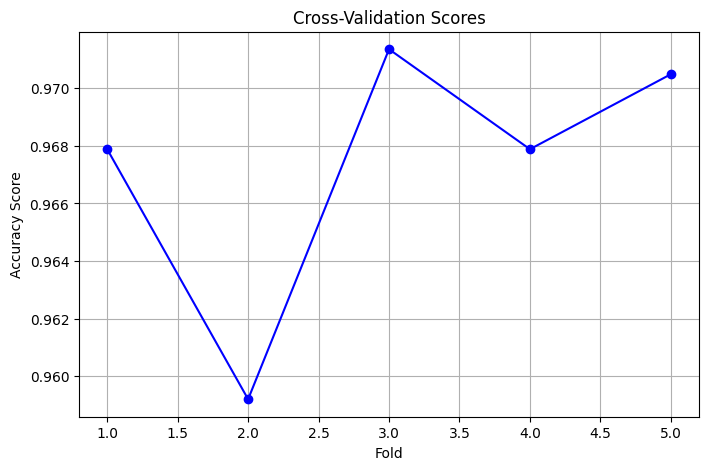

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), scores_rbf, marker='o', linestyle='-', color='blue')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Scores')
plt.grid(True)
plt.show()

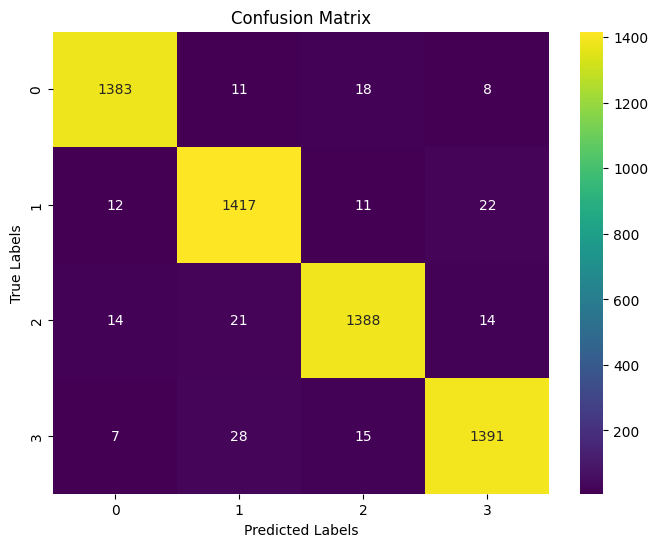

In [20]:
conf_matrix_rbf = confusion_matrix(best_rbf_fold_y_test, predicted_labels)

# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rbf, annot=True, fmt='g', cmap='viridis', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
sensitivity = conf_matrix_rbf[1, 1] / (conf_matrix_rbf[1, 0] + conf_matrix_rbf[1, 1])
specificity = conf_matrix_rbf[0, 0] / (conf_matrix_rbf[0, 0] + conf_matrix_rbf[0, 1])

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.9916025192442267
Specificity: 0.9921090387374462


### 5.2 Kernel Polinomial

Training

In [22]:
svm_poly = SVC(kernel='poly', probability=True, decision_function_shape='ovr')
scores_poly = cross_val_score(svm_poly, flat_feat_trainCNN, np.argmax(Y_train, axis=1), cv=5, scoring='accuracy')

print("Skor Akurasi untuk Setiap Fold:")
print(scores_poly)
print("\nRata-rata Skor Akurasi:")
print(scores_poly.mean())

Skor Akurasi untuk Setiap Fold:
[0.95920139 0.94618056 0.96875    0.96267361 0.96527778]

Rata-rata Skor Akurasi:
0.9604166666666668


In [23]:
fold_predictions = cross_val_predict(svm_poly, flat_feat_trainCNN, np.argmax(Y_train, axis=1), cv=5, method='predict_proba')

best_poly_fold_index = np.argmax(scores_poly)
best_poly_fold_y_test = np.argmax(Y_train, axis=1)
best_poly_fold_y_pred = fold_predictions

Simpan model

In [24]:
model_svm_poly = r"D:/Users/RESA/Coding/Evaluasi/svm_model_poly.pkl"
with open(model_svm_poly, 'wb') as model_file:
    pickle.dump(svm_poly, model_file)
print("Model SVM poly telah disimpan di:", model_svm_poly)

Model SVM poly telah disimpan di: D:/Users/RESA/Coding/Evaluasi/svm_model_poly.pkl


Testing

In [25]:
svm_poly.fit(flat_feat_trainCNN, np.argmax(Y_train, axis=1))
predictions_test = svm_poly.predict(flat_feat_testCNN)
print("Label Sebenarnya:")
print(np.argmax(Y_test, axis=1))
print("\nLabel Prediksi:")
print(predictions_test)
accuracy_test = np.mean(predictions_test == np.argmax(Y_test, axis=1))
print("\nAkurasi pada Data Uji:", accuracy_test)

Label Sebenarnya:
[1 1 2 ... 3 1 1]

Label Prediksi:
[0 1 2 ... 3 1 3]

Akurasi pada Data Uji: 0.9263888888888889


Evaluasi

In [26]:
predicted_labels = np.argmax(best_poly_fold_y_pred, axis=1)

print("\nClassification Report for the Fold with the Highest Accuracy:")
print(classification_report(best_poly_fold_y_test, predicted_labels))


Classification Report for the Fold with the Highest Accuracy:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1420
           1       0.96      0.97      0.96      1462
           2       0.96      0.97      0.96      1437
           3       0.98      0.96      0.97      1441

    accuracy                           0.96      5760
   macro avg       0.97      0.96      0.96      5760
weighted avg       0.96      0.96      0.96      5760



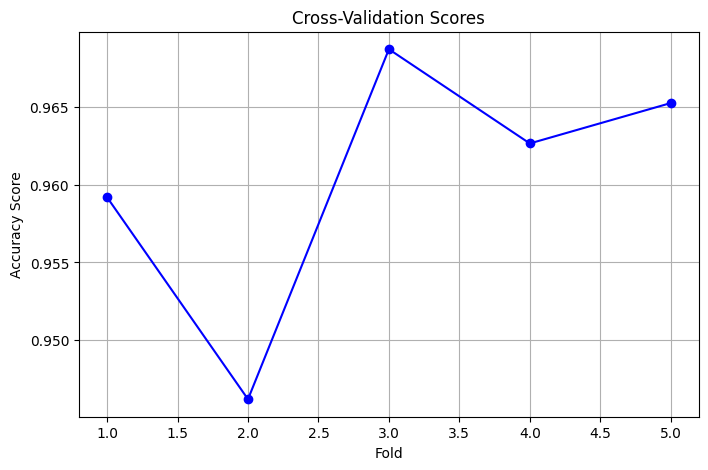

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), scores_poly, marker='o', linestyle='-', color='blue')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Scores')
plt.grid(True)
plt.show()

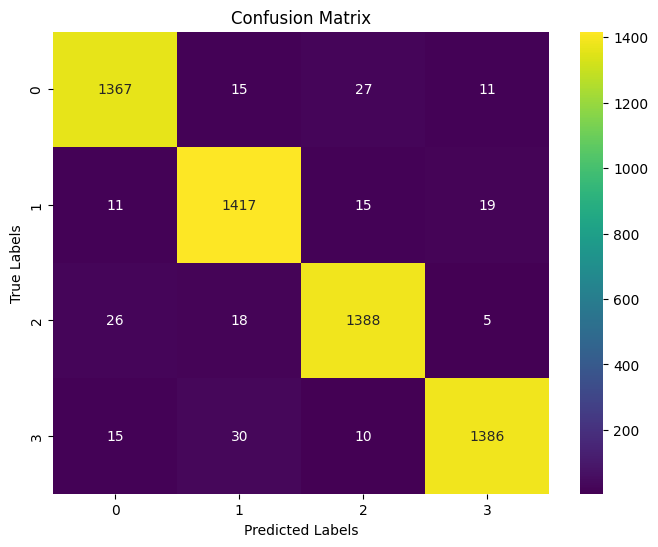

In [28]:
conf_matrix_poly = confusion_matrix(best_poly_fold_y_test, predicted_labels)

# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_poly, annot=True, fmt='g', cmap='viridis', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
sensitivity = conf_matrix_poly[1, 1] / (conf_matrix_poly[1, 0] + conf_matrix_poly[1, 1])
specificity = conf_matrix_poly[0, 0] / (conf_matrix_poly[0, 0] + conf_matrix_poly[0, 1])

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.992296918767507
Specificity: 0.9891461649782923
